In [1]:
import sys
print(sys.executable)

import tensorflow as tf
import keras
import tf_keras
import deepface

print("tf:", tf.__version__)
print("keras:", keras.__version__)
print("tf_keras:", tf_keras.__version__)
print("deepface:", deepface.__version__)


C:\Users\Soldinho\PycharmProjects\PythonProject3\.venv_deepface\Scripts\python.exe

tf: 2.15.1
keras: 2.15.0
tf_keras: 2.15.0
deepface: 0.0.97


In [2]:
import os
import cv2
import time
from deepface import DeepFace

# Βασικές κατηγορίες συναισθήματος
EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

def safe_scores(emotion_dict):
    # Μετατρέπει scores σε 0..1 (μερικές φορές DeepFace δίνει 0..100)
    scores = {}
    for k in EMOTIONS:
        v = float(emotion_dict.get(k, 0.0))
        scores[k] = v / 100.0 if v > 1.0 else v
    return scores

def resize_keep_aspect(image_bgr, max_side=900):
    # Κρατάει αναλογία και μειώνει την εικόνα αν είναι πολύ μεγάλη
    h, w = image_bgr.shape[:2]
    scale = min(1.0, max_side / float(max(h, w)))
    if scale == 1.0:
        return image_bgr, 1.0
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized = cv2.resize(image_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized, scale




In [3]:
def analyze_frame_deepface(frame_bgr, detector_backend="opencv"):
    # Εκτελεί face detection + emotion classification σε ένα frame (numpy array)
    h_img, w_img = frame_bgr.shape[:2]

    result = DeepFace.analyze(
        img_path=frame_bgr,
        actions=["emotion"],
        detector_backend=detector_backend,
        enforce_detection=False)

    faces = result if isinstance(result, list) else [result]
    detections = []

    for f in faces:
        region = f.get("region", {}) or {}
        x = int(region.get("x", 0))
        y = int(region.get("y", 0))
        w = int(region.get("w", 0))
        h = int(region.get("h", 0))

        x1, y1 = max(0, x), max(0, y)
        x2, y2 = min(w_img, x + w), min(h_img, y + h)
        if x2 <= x1 or y2 <= y1:
            continue

        emo_dict = f.get("emotion", {}) or {}
        label = f.get("dominant_emotion", None)
        if label is None:
            continue

        scores = safe_scores(emo_dict)
        confidence = float(scores.get(label, 0.0))

        detections.append({
            "bbox": (x1, y1, x2, y2),
            "label": label,
            "confidence": confidence,
            "scores": scores})

    return detections

In [4]:
def scale_detections(detections, inv_scale):
    # Κλιμακώνει bbox από resized εικόνα πίσω στο αρχικό μέγεθος
    scaled = []
    for d in detections:
        x1, y1, x2, y2 = d["bbox"]
        scaled.append({
            **d,
            "bbox": (int(x1 * inv_scale), int(y1 * inv_scale), int(x2 * inv_scale), int(y2 * inv_scale))})
    return scaled



In [5]:
def draw_detections(image_bgr, detections):
    # Ζωγραφίζει bbox + label με δυναμικό μέγεθος γραμματοσειράς/πάχους
    annotated = image_bgr.copy()
    h, w = annotated.shape[:2]

    # Υπολογισμός κλίμακας κειμένου με βάση το μέγεθος της εικόνας
    # 900px περίπου -> font ~0.7 , πιο μεγάλα -> μεγαλύτερο font
    base = max(h, w)
    font_scale = max(0.6, min(2.0, base / 1200.0))     # 0.6..2.0
    thickness = max(2, min(6, int(base / 600.0)))      # 2..6
    pad = max(4, int(base / 300.0))                    # padding για το label box

    for d in detections:
        x1, y1, x2, y2 = d["bbox"]
        label = d["label"]
        conf = d["confidence"]

        text = f"{label} ({conf:.2f})"

        # Bounding box
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), thickness)

        # Μέγεθος κειμένου
        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        # Θέση label (πάνω από το bbox, αλλιώς μέσα)
        tx1 = x1
        ty1 = y1 - th - 2 * pad
        if ty1 < 0:
            ty1 = y1 + 2 * pad

        # Background rectangle για να φαίνεται πάντα το κείμενο
        cv2.rectangle(
            annotated,
            (tx1, ty1),
            (tx1 + tw + 2 * pad, ty1 + th + 2 * pad),
            (0, 255, 0),
            -1)

        # Κείμενο
        cv2.putText(
            annotated,
            text,
            (tx1 + pad, ty1 + th + pad),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (0, 0, 0),
            thickness,
            cv2.LINE_AA)

    return annotated

In [6]:
def run_image_mode(image_path, detector_backend="opencv", max_side_infer=900, max_side_view=900):
    # Τρέχει σε εικόνα από δίσκο με auto-resize
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Δεν βρέθηκε/διαβάστηκε η εικόνα: {image_path}")

    small, scale = resize_keep_aspect(img, max_side=max_side_infer)
    detections_small = analyze_frame_deepface(small, detector_backend=detector_backend)

    inv = 1.0 / scale
    detections = scale_detections(detections_small, inv)

    annotated_full = draw_detections(img, detections)

    print("Detections:")
    for d in detections:
        print(d)

    out_path = os.path.join(os.getcwd(), "annotated_image_deepface.jpg")
    cv2.imwrite(out_path, annotated_full)
    print("Αποθηκεύτηκε:", out_path)

    # Για προβολή: δείχνουμε πάντα resized ώστε να χωράει στην οθόνη
    view, _ = resize_keep_aspect(annotated_full, max_side=max_side_view)
    cv2.imshow("Image Emotion Detection (DeepFace) - view", view)
    cv2.waitKey(15000)
    cv2.destroyAllWindows()

    return detections, annotated_full


In [7]:
def run_webcam_mode(camera_index=0, detector_backend="opencv",
                    analyze_every_n_frames=15, max_side_infer=900, max_side_view=900):
    # Τρέχει σε webcam stream με auto-resize για ταχύτητα
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        raise RuntimeError("Δεν άνοιξε η webcam. Δοκίμασε camera_index=1 ή έλεγξε permissions.")

    last_detections_full = []
    frame_id = 0
    last_time = time.time()
    fps = 0.0

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        frame_id += 1

        now = time.time()
        dt = now - last_time
        if dt > 0:
            fps = 1.0 / dt
        last_time = now

        # Resize για inference (γρηγορότερο)
        small, scale = resize_keep_aspect(frame, max_side=max_side_infer)
        inv = 1.0 / scale

        if frame_id % analyze_every_n_frames == 0:
            try:
                det_small = analyze_frame_deepface(small, detector_backend=detector_backend)
                last_detections_full = scale_detections(det_small, inv)
            except Exception:
                # Αν αποτύχει σε κάποιο frame, κρατάμε τα προηγούμενα detections
                pass

        annotated_full = draw_detections(frame, last_detections_full)

        cv2.putText(
            annotated_full,
            f"FPS: {fps:.1f} | analyze every {analyze_every_n_frames} frames | q: exit",
            (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 255),
            2,
            cv2.LINE_AA)

        # View resize για να χωράει στην οθόνη
        view, _ = resize_keep_aspect(annotated_full, max_side=max_side_view)
        cv2.imshow("Webcam Emotion Detection (DeepFace) - view", view)

        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

In [23]:
if __name__ == "__main__":
    # Αν υπάρχει εικόνα -> image mode, αλλιώς -> webcam mode
    IMAGE_NAME = "image21.jpg"
    image_path = os.path.join(os.getcwd(), IMAGE_NAME)

    if os.path.exists(image_path):
        print(f"Βρέθηκε εικόνα: {IMAGE_NAME} -> IMAGE mode")
        run_image_mode(
            image_path,
            detector_backend="opencv",
            max_side_infer=900,
            max_side_view=900)
    else:
        print(f"Δεν βρέθηκε {IMAGE_NAME} -> WEBCAM mode")
        run_webcam_mode(
            camera_index=0,
            detector_backend="opencv",
            analyze_every_n_frames=8,
            max_side_infer=900,
            max_side_view=900)

Βρέθηκε εικόνα: image21.jpg -> IMAGE mode
Detections:
{'bbox': (1805, 3820, 2175, 4190), 'label': 'happy', 'confidence': 0.8608117699623108, 'scores': {'angry': 0.024048201739788055, 'disgust': 0.00042266228774678893, 'fear': 0.0006497669801319716, 'happy': 0.8608117699623108, 'sad': 0.11340218782424927, 'surprise': 2.5087638633181086e-06, 'neutral': 0.1727109425701201}}
{'bbox': (810, 930, 2480, 2600), 'label': 'happy', 'confidence': 0.999982476232347, 'scores': {'angry': 8.956918053628363e-06, 'disgust': 1.1798179671969912e-11, 'fear': 0.0001593065993626029, 'happy': 0.999982476232347, 'sad': 0.0007599267060914947, 'surprise': 0.0001398323827998957, 'neutral': 0.0006932599634337475}}
Αποθηκεύτηκε: C:\Users\Soldinho\PycharmProjects\PythonProject3\annotated_image_deepface.jpg


In [9]:
import sys
! "{sys.executable}" -m pip install --upgrade pip
! "{sys.executable}" -m pip install matplotlib==3.8.4


In [10]:
import os
import time
from collections import Counter, deque
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace

# Βασικές κατηγορίες συναισθημάτων
EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

def safe_scores(emotion_dict):
    # Μετατρέπει scores σε 0..1
    scores = {}
    for k in EMOTIONS:
        v = float(emotion_dict.get(k, 0.0))
        scores[k] = v / 100.0 if v > 1.0 else v
    return scores

def analyze_frame_emotion(frame_bgr):
    # Κάνει emotion analysis σε frame (numpy array) και επιστρέφει (label, confidence)
    result = DeepFace.analyze(
        img_path=frame_bgr,
        actions=["emotion"],
        detector_backend="opencv",
        enforce_detection=False)

    faces = result if isinstance(result, list) else [result]
    if len(faces) == 0:
        return None, None

    # Παίρνουμε το πρώτο πρόσωπο για πιο απλό timeline
    f = faces[0]
    label = f.get("dominant_emotion", None)
    emo_dict = f.get("emotion", {}) or {}
    if label is None:
        return None, None

    scores = safe_scores(emo_dict)
    conf = float(scores.get(label, 0.0))
    return label, conf

In [11]:
def list_images_in_cwd(extensions=(".jpg", ".jpeg", ".png")):
    # Επιστρέφει όλες τις εικόνες στον ίδιο φάκελο με το notebook (working directory)
    files = []
    for fn in os.listdir(os.getcwd()):
        low = fn.lower()
        if low.endswith(extensions):
            # Αγνοεί outputs που μπορεί να παραχθούν
            if low.startswith("annotated_"):
                continue
            files.append(fn)
    files.sort()
    return [os.path.join(os.getcwd(), f) for f in files]

def run_images_and_collect(image_paths, show_preview=True, max_side_preview=900):
    # Συλλέγει emotions από πολλαπλές εικόνες
    timeline = []          # (t, label, conf)
    counts = Counter()     # συνολικές μετρήσεις
    recent = deque(maxlen=30)

    start = time.time()

    for idx, path in enumerate(image_paths):
        img = cv2.imread(path)
        if img is None:
            continue

        label, conf = analyze_frame_emotion(img)
        t = time.time() - start  # χρόνος (sec) από την αρχή του session

        if label is not None:
            timeline.append((t, label, conf))
            counts[label] += 1
            recent.append(label)

        # Εμφάνιση preview
        if show_preview:
            preview = img.copy()
            text = f"{os.path.basename(path)} -> {label} ({conf:.2f})" if label else f"{os.path.basename(path)} -> no face"
            cv2.putText(preview, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2, cv2.LINE_AA)

            # Resize για να χωράει πάντα στην οθόνη
            h, w = preview.shape[:2]
            scale = min(1.0, max_side_preview / float(max(h, w)))
            if scale < 1.0:
                preview = cv2.resize(preview, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

            cv2.imshow("Images Session Preview", preview)
            key = cv2.waitKey(500) & 0xFF  # 0.5 sec ανά εικόνα
            if key == ord("q"):
                break

    cv2.destroyAllWindows()
    return timeline, counts

In [12]:
def run_session_and_collect(duration_sec=20, analyze_every_n_frames=8, camera_index=0):
    # Συλλέγει emotions για Χ δευτερόλεπτα από webcam
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        raise RuntimeError("Δεν άνοιξε η webcam. Δοκίμασε camera_index=1 ή έλεγξε permissions.")

    start = time.time()
    frame_id = 0

    timeline = []      # (t, label, conf)
    counts = Counter()
    recent = deque(maxlen=30)

    last_label = None
    last_conf = None

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        frame_id += 1
        t = time.time() - start

        if t >= duration_sec:
            break

        if frame_id % analyze_every_n_frames == 0:
            label, conf = analyze_frame_emotion(frame)
            if label is not None:
                last_label, last_conf = label, conf
                timeline.append((t, label, conf))
                counts[label] += 1
                recent.append(label)

        # Εμφάνιση στην οθόνη
        show = frame.copy()
        if last_label is not None:
            cv2.putText(
                show,
                f"{last_label} ({last_conf:.2f})",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.0,
                (255, 255, 255),
                2,
                cv2.LINE_AA)
        cv2.putText(
            show,
            f"t={t:.1f}s  (press q to stop)",
            (10, 65),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 255),
            2,
            cv2.LINE_AA)

        cv2.imshow("Emotion Session Capture", show)
        if (cv2.waitKey(1) & 0xFF) == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

    return timeline, counts


In [13]:
def plot_emotion_distribution(timeline, counts):
    # Bar chart: cumulative counts
    labels = EMOTIONS
    values = [counts.get(e, 0) for e in labels]

    plt.figure()
    plt.bar(labels, values)
    plt.title("Cumulative Emotion Counts")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Line chart: emotion over time (ως index)
    if len(timeline) > 0:
        t_vals = [x[0] for x in timeline]
        emo_idx = [EMOTIONS.index(x[1]) for x in timeline]

        plt.figure()
        plt.plot(t_vals, emo_idx, marker="o")
        plt.title("Emotion Changes Over Time (index-coded)")
        plt.xlabel("Time (sec)")
        plt.ylabel("Emotion (index)")
        plt.yticks(range(len(EMOTIONS)), EMOTIONS)
        plt.tight_layout()
        plt.show()

    # Pie chart: dominant emotions during session
    total = sum(values)
    if total > 0:
        plt.figure()
        plt.pie(values, labels=labels, autopct="%1.1f%%")
        plt.title("Dominant Emotions During Session")
        plt.tight_layout()
        plt.show()

Βρέθηκαν 23 εικόνες -> IMAGES mode
Counts: Counter({'sad': 9, 'neutral': 4, 'angry': 3, 'surprise': 3, 'fear': 2, 'disgust': 1, 'happy': 1})


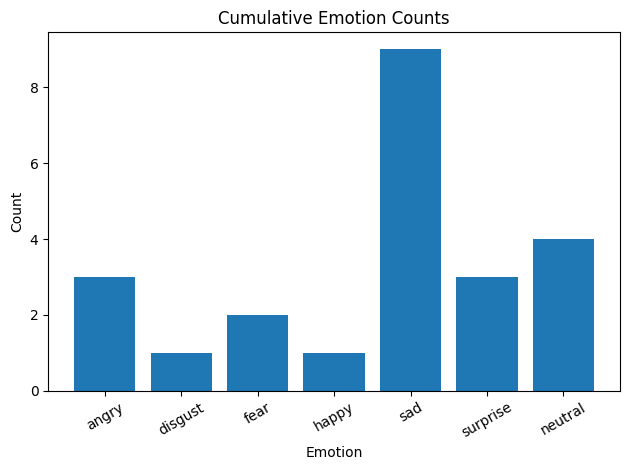

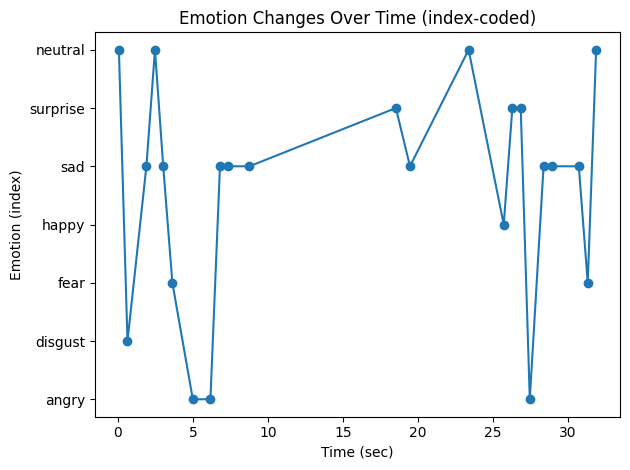

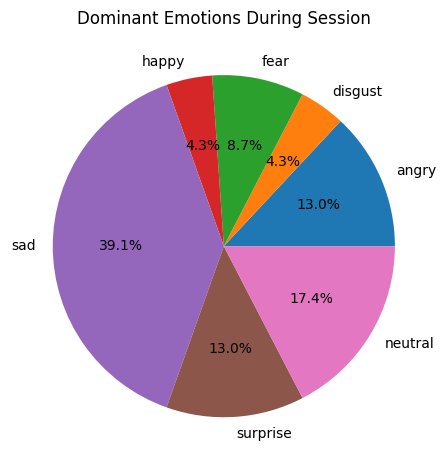

Interpretation: Υπάρχει εναλλαγή συναισθημάτων: κυρίως 'sad' και 'neutral'. Αυτό δείχνει πιο μεταβαλλόμενη συναισθηματική κατάσταση στη διάρκεια της συνεδρίας.


In [14]:
def interpret_pattern(counts):
    # Σύντομη ερμηνεία συναισθηματικού μοτίβου
    if sum(counts.values()) == 0:
        return "Δεν ανιχνεύτηκαν αρκετά πρόσωπα/συναισθήματα για ασφαλές συμπέρασμα."

    dominant, dom_count = counts.most_common(1)[0]
    total = sum(counts.values())
    ratio = dom_count / total

    if ratio >= 0.6:
        return f"Το κυρίαρχο συναίσθημα ήταν το '{dominant}' (~{ratio:.0%} των προβλέψεων), άρα το μοτίβο εμφανίζεται σχετικά σταθερό."
    else:
        top2 = counts.most_common(2)
        if len(top2) > 1:
            return f"Υπάρχει εναλλαγή συναισθημάτων: κυρίως '{top2[0][0]}' και '{top2[1][0]}'. Αυτό δείχνει πιο μεταβαλλόμενη συναισθηματική κατάσταση στη διάρκεια της συνεδρίας."
        return f"Το πιο συχνό συναίσθημα ήταν '{dominant}', αλλά χωρίς έντονη κυριαρχία."

# AUTO RUN: εικόνες αν υπάρχουν, αλλιώς webcam
image_paths = list_images_in_cwd()

if len(image_paths) > 0:
    print(f"Βρέθηκαν {len(image_paths)} εικόνες -> IMAGES mode")
    timeline, counts = run_images_and_collect(image_paths, show_preview=True)
else:
    print("Δεν βρέθηκαν εικόνες -> WEBCAM mode")
    timeline, counts = run_session_and_collect(duration_sec=20, analyze_every_n_frames=8, camera_index=0)

print("Counts:", counts)
plot_emotion_distribution(timeline, counts)
print("Interpretation:", interpret_pattern(counts))

In [15]:
import json

def build_detected_objects_payload(detections):
    # Μετατρέπει τα detections (faces+emotions) σε "objects" που θα στείλουμε στο LLM
    # Κρατάμε τα βασικά για να είναι καθαρό το prompt
    objects = []
    for d in detections:
        x1, y1, x2, y2 = d.get("bbox", (0,0,0,0))
        objects.append({
            "type": "face",
            "emotion": d.get("label", "unknown"),
            "confidence": round(float(d.get("confidence", 0.0)), 3),
            "bbox": [int(x1), int(y1), int(x2), int(y2)]})
    return objects

def build_prompt(objects, prompt_style="concise", language="en"):
    # Χτίζει διαφορετικά prompt styles για να κάνουμε prompt engineering
    # Το LLM θα απαντάει στα Αγγλικά για να ταιριάζει με τα emotion labels (happy/surprise/etc)

    objects_json = json.dumps(objects, ensure_ascii=False)

    if prompt_style == "concise":
        return f"""
You are an image description assistant.
I will give you computer vision detections (objects).
Write ONE short paragraph (2-3 sentences) in English.

Rules:
- Use ONLY the provided detections.
- Do NOT invent background, context, or extra objects.
- Do NOT mention technical terms (bbox, json, confidence).
- You may mention how many faces are present and the dominant emotion(s).
- If an emotion is provided, repeat it EXACTLY as given (e.g., "surprise", "happy").

Detected objects:
{objects_json}
""".strip()

    if prompt_style == "neutral_tone":
        return f"""
You are an assistant that describes an image ONLY using the provided detections.
Write a short paragraph (3-4 sentences) in English. Keep it neutral and factual.
Do not invent extra objects or a background.
If only faces/emotions are provided, describe only that.
Repeat emotion labels exactly as given.

Detected objects (JSON):
{objects_json}
""".strip()

    if prompt_style == "focus_emotion":
        return f"""
Write an image description with emphasis on emotion.
Use ONLY the detections below.
Write 2-3 sentences in English:
- How many faces are present
- Which emotion(s) are dominant
- Natural text, without percentages and without technical details
Repeat emotion labels exactly as given.

Detections:
{objects_json}
""".strip()

    if prompt_style == "bullet_then_summary":
        return f"""
I will give you detections.
First write 2 bullet points with facts (e.g., number of faces, dominant emotion).
Then write ONE short summary sentence in English.
No guesses. No background. No extra objects.
Repeat emotion labels exactly as given.

Detections:
{objects_json}
""".strip()

    # Προεπιλογή αν δοθεί άγνωστο style
    return build_prompt(objects, prompt_style="focus_emotion", language=language)


def ollama_generate_description(detections, model="gemma3", prompt_style="concise", temperature=0.3):
    # Καλεί το Ollama τοπικά και επιστρέφει την περιγραφή
    # Βασίζεται στο ollama.chat
    # τemperature=0.3 ώστε το μοντέλο να μην επιλέγει τυχαία λέξεις, αλλά να είναι και ευέλικτο
    objects = build_detected_objects_payload(detections)

    # Αν δεν βρεθεί τίποτα, δίνουμε “ασφαλή” απάντηση
    if len(objects) == 0:
        return "Δεν εντοπίστηκαν πρόσωπα/αντικείμενα στα αποτελέσματα ανίχνευσης, οπότε δεν μπορώ να δώσω αξιόπιστη περιγραφή."

    prompt = build_prompt(objects, prompt_style=prompt_style)

    try:
        response = ollama.chat(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            options={"temperature": float(temperature)})

        return response["message"]["content"].strip()
    except Exception as e:
        # Συνήθως εδώ πέφτουμε αν δεν τρέχει το ollama service ή αν το model name είναι λάθος
        return f"Σφάλμα κατά την κλήση του Ollama: {e}"


In [16]:
def simple_text_eval(detections, generated_text):
    # Απλό metric:
    # coverage = πόσα από τα detected emotions εμφανίζονται στο κείμενο
    # hallucination = πόσα emotions εμφανίζονται στο κείμενο αλλά ΔΕΝ ανιχνεύτηκαν

    detected = [d.get("label","").lower().strip() for d in detections if d.get("label")]
    detected_set = set(detected)

    # Τα 7 βασικά emotions όπως τα χρησιμοποιούμε ήδη
    all_emotions = {"angry","disgust","fear","happy","sad","surprise","neutral"}

    text = generated_text.lower()

    mentioned = set()
    for emo in all_emotions:
        # απλή αναζήτηση λέξης (π.χ. "happy")
        if re.search(rf"\b{re.escape(emo)}\b", text):
            mentioned.add(emo)

    if len(detected_set) == 0:
        return {"coverage": 0.0, "hallucination": float(len(mentioned)), "mentioned": sorted(list(mentioned))}

    coverage = len(mentioned.intersection(detected_set)) / len(detected_set)
    hallucination = len(mentioned - detected_set)

    return {
        "coverage": round(float(coverage), 3),
        "hallucination": float(hallucination),
        "detected": sorted(list(detected_set)),
        "mentioned": sorted(list(mentioned))}


In [24]:
# Τρέχει μια εικόνα, παίρνει detections, και μετά στέλνει τα detections στο LLM επιλέγοντας είδος prompt
# από την μεταβλητή prompt_style.

image_path = "image10.jpg"
detections, annotated_bgr = run_image_mode(image_path, detector_backend="opencv")

desc = ollama_generate_description(detections, model="gemma3", prompt_style="focus_emotion", temperature=0.3)
print(desc)
print("Eval:", simple_text_eval(detections, desc))


Detections:
{'bbox': (129, 62, 387, 320), 'label': 'neutral', 'confidence': 0.738507970482586, 'scores': {'angry': 0.06189462538925561, 'disgust': 0.0013138491213834788, 'fear': 0.061153154739925546, 'happy': 0.4995976872502379, 'sad': 0.1332988669454376, 'surprise': 0.013626679076913242, 'neutral': 0.738507970482586}}
Αποθηκεύτηκε: C:\Users\Soldinho\PycharmProjects\PythonProject3\annotated_image_deepface.jpg
There is one face present in the image. The dominant emotion is **neutral**, suggesting a sense of calm or perhaps detachment. The expression appears thoughtful and unengaged, conveying a quiet stillness.
Eval: {'coverage': 1.0, 'hallucination': 0.0, 'detected': ['neutral'], 'mentioned': ['neutral']}


In [18]:
import ollama
import time

#Καλούμε client γιατί παρατηρήσαμε πως αργούσε πολύ να παράξει κείμενο
client = ollama.Client(host="http://127.0.0.1:11434")

def generate_for_style(detections, style, model="gemma3", temperature=0.3):
    # Παράγει απάντηση για συγκεκριμένο prompt style
    # Περιορίζουμε το μήκος για γρήγορες και συγκρίσιμες απαντήσεις

    objects = build_detected_objects_payload(detections)
    prompt = build_prompt(objects, prompt_style=style)

    t0 = time.time()
    resp = client.chat(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        options={
            "temperature": float(temperature),
            "num_predict": 120},
        stream=False)

    dt = time.time() - t0
    text = resp["message"]["content"].strip()

    return text, dt


In [19]:
import re

def eval_response(detections, text):
    # Αξιολογεί την απάντηση με βάση τα detections
    # Η πραγματολογική ακρίβεια εδώ σημαίνει: να μην “εφευρίσκει” συναισθήματα

    detected = [d.get("label","").lower().strip() for d in detections if d.get("label")]
    detected_set = set(detected)

    # Τα βασικά emotions που περιμένουμε από DeepFace
    all_emotions = {"angry","disgust","fear","happy","sad","surprise","neutral"}

    low = text.lower()

    mentioned = set()
    for emo in all_emotions:
        if re.search(rf"\b{re.escape(emo)}\b", low):
            mentioned.add(emo)

    if len(detected_set) == 0:
        coverage = 0.0
    else:
        coverage = len(mentioned.intersection(detected_set)) / len(detected_set)

    hallucination = len(mentioned - detected_set)

    # Απλά heuristics για καθαρότητα/συνοχή
    words = re.findall(r"\S+", text)
    word_count = len(words)

    sentences = re.split(r"[.!?…]+", text.strip())
    sentence_count = len([s for s in sentences if s.strip()])

    mentions_technical = int(("json" in low) or ("bbox" in low) or ("confidence" in low))

    return {
        "coverage": round(float(coverage), 3),
        "hallucination": int(hallucination),
        "word_count": int(word_count),
        "sentence_count": int(sentence_count),
        "mentions_technical": int(mentions_technical),
        "detected_emotions": sorted(list(detected_set)),
        "mentioned_emotions": sorted(list(mentioned)),}


In [25]:
import pandas as pd

# Αν δεν υπάρχουν detections (π.χ. μετά από restart), σταματάει με καθαρό μήνυμα
assert "detections" in globals(), "Δεν υπάρχει η μεταβλητή detections. Τρέξε πρώτα run_image_mode(...)"

prompt_styles = ["concise", "neutral_tone", "focus_emotion", "bullet_then_summary"]

rows = []

for style in prompt_styles:
    # Παράγουμε απάντηση για το συγκεκριμένο prompt style
    out_text, latency = generate_for_style(detections, style, model="gemma3", temperature=0.3)

    # Υπολογίζουμε τα metrics
    scores = eval_response(detections, out_text)

    # Αποθηκεύουμε τα αποτελέσματα για να τα κάνουμε DataFrame
    rows.append({
        "prompt_style": style,
        "latency_sec": round(float(latency), 2),
        "coverage": scores["coverage"],
        "hallucination": scores["hallucination"],
        "word_count": scores["word_count"],
        "sentence_count": scores["sentence_count"],
        "mentions_technical": scores["mentions_technical"],
        "output_text": out_text})

# Φτιάχνουμε το DataFrame αφού γεμίσει το rows
df_prompts = pd.DataFrame(rows)

# Τυπώνουμε αναλυτικά όλες τις απαντήσεις
for _, row in df_prompts.iterrows():
    print("=" * 80)
    print("Prompt style:", row["prompt_style"])
    print("Latency (sec):", row["latency_sec"])
    print("Coverage:", row["coverage"], "| Hallucination:", row["hallucination"])
    print("Word count:", row["word_count"], "| Sentence count:", row["sentence_count"])
    print("Mentions technical:", row["mentions_technical"])
    print("-" * 80)
    print(row["output_text"])
    print("=" * 80, "\n")


Prompt style: concise
Latency (sec): 12.3
Coverage: 1.0 | Hallucination: 0
Word count: 29 | Sentence count: 3
Mentions technical: 0
--------------------------------------------------------------------------------
There is one face in the image, and it appears neutral. The person in the image seems to be experiencing neutral emotions. It’s a straightforward depiction of a face.

Prompt style: neutral_tone
Latency (sec): 8.78
Coverage: 1.0 | Hallucination: 0
Word count: 42 | Sentence count: 5
Mentions technical: 1
--------------------------------------------------------------------------------
The image contains a single face. The detected face has a neutral emotion. The confidence score for the emotion detection is 0.739. The bounding box for the face indicates it occupies the area from x=129 to x=387 and from y=62 to y=320.

Prompt style: focus_emotion
Latency (sec): 6.34
Coverage: 1.0 | Hallucination: 0
Word count: 34 | Sentence count: 3
Mentions technical: 0
-------------------------

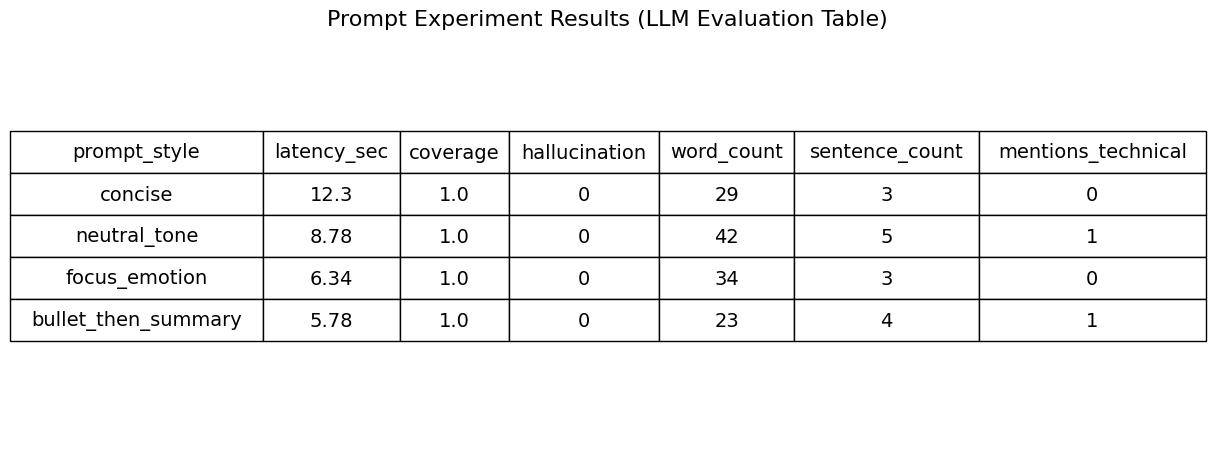

In [26]:
import matplotlib.pyplot as plt

# Διαλέγουμε ποιες στήλες θέλουμε να φαίνονται στον πίνακα
cols = ["prompt_style", "latency_sec", "coverage", "hallucination", "word_count", "sentence_count", "mentions_technical"]

# Φτιάχνουμε ένα "καθαρό" df για εμφάνιση
df_tbl = df_prompts[cols].copy()
df_tbl["latency_sec"] = df_tbl["latency_sec"].round(2)
df_tbl["coverage"] = df_tbl["coverage"].round(3)

# Μετατρέπουμε σε strings για σωστή εμφάνιση στον πίνακα
cell_text = df_tbl.astype(str).values.tolist()
col_labels = df_tbl.columns.tolist()

# Ρυθμίσεις μεγέθους για πιο μεγάλα κουτιά/στήλες
n_rows, n_cols = df_tbl.shape

# Μεγαλώνουμε το figure (πλάτος/ύψος)
fig_w = 2.0 + 1.6 * n_cols
fig_h = 1.8 + 0.7 * n_rows

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis("off")

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc="center",
    loc="center")

# Μεγαλώνουμε γραμματοσειρά και “κουτιά” (scale)
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.0, 2.2)

# Κάνουμε τις στήλες λίγο πιο φαρδιές με fixed widths
for c in range(n_cols):
    table.auto_set_column_width(col=c)

plt.title("Prompt Experiment Results (LLM Evaluation Table)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#ΜΟΝΤΕΛΟ ΓΙΑ ΦΛΑΣΚ ΓΙΑ ΤΟΠΙΚΗ ΧΡΗΣΗ ΜΕ OLLAMA KAI GEMMA3

import os
import time
import json
from uuid import uuid4

import cv2
from deepface import DeepFace
import ollama

from flask import Flask, render_template, request, redirect, url_for, session, flash, send_from_directory
from werkzeug.utils import secure_filename


# Ρυθμίζουμε Flask ώστε:
# - templates να διαβάζονται από τον φάκελο "templates"
# - static αρχεία (CSS) να σερβίρονται από τον φάκελο "css"
# Το static_url_path="/css" σημαίνει ότι το CSS θα φορτώνεται από /css/...
app = Flask(__name__, template_folder="templates", static_folder="css", static_url_path="/css")

app.secret_key = "change_this_secret_key"
app.config["UPLOAD_FOLDER"] = os.path.join(os.getcwd(), "uploads")
app.config["MAX_CONTENT_LENGTH"] = 10 * 1024 * 1024  # 10MB

ALLOWED_EXTENSIONS = {"png", "jpg", "jpeg", "webp"}

OLLAMA_HOST = "http://127.0.0.1:11434"
OLLAMA_MODEL = "gemma3"
ollama_client = ollama.Client(host=OLLAMA_HOST)

os.makedirs(app.config["UPLOAD_FOLDER"], exist_ok=True)


def allowed_file(filename: str) -> bool:
    # Ελέγχουμε την κατάληξη του αρχείου
    if "." not in filename:
        return False
    ext = filename.rsplit(".", 1)[1].lower().strip()
    return ext in ALLOWED_EXTENSIONS


def build_detected_objects_payload(detections):
    # Φτιάχνουμε μικρό JSON payload για να μην βαραίνει το prompt
    objects = []
    for d in detections:
        x1, y1, x2, y2 = d.get("bbox", (0, 0, 0, 0))
        objects.append({
            "type": "face",
            "emotion": d.get("label", "unknown"),
            "confidence": round(float(d.get("confidence", 0.0)), 3),
            "bbox": [int(x1), int(y1), int(x2), int(y2)]
        })
    return objects


def build_prompt(objects, prompt_style="focus_emotion"):
    # Prompts στα Αγγλικά για να ταιριάζουν με labels τύπου happy/surprise/etc
    objects_json = json.dumps(objects, ensure_ascii=False)

    if prompt_style == "bullet_then_summary":
        return f"""
I will give you detections.
First write 2 bullet points with facts (e.g., number of faces, dominant emotion).
Then write ONE short summary sentence in English.
No guesses. No background. No extra objects.
Repeat emotion labels exactly as given.

Detections:
{objects_json}
""".strip()

    if prompt_style == "focus_emotion":
        return f"""
You will receive detections from computer vision.
Write a short image description (2-3 sentences) in English with emphasis on emotion.

Rules:
- Use ONLY the provided detections.
- Do NOT invent background, context, or extra objects.
- Do NOT mention technical terms (bbox, json, confidence).
- Mention how many faces are present.
- Mention the dominant emotion(s) and repeat emotion labels EXACTLY as given (e.g., "surprise", "happy").
- Do not translate the emotion labels into other words.

Detections:
{objects_json}
""".strip()

    return f"""
You are an image description assistant.
I will give you computer vision detections (objects).
Write ONE short paragraph (2-3 sentences) in English.

Rules:
- Use ONLY the provided detections.
- Do NOT invent background, context, or extra objects.
- Do NOT mention technical terms (bbox, json, confidence).
- You may mention how many faces are present and the dominant emotion(s).
- If an emotion is provided, repeat it EXACTLY as given (e.g., "surprise", "happy").

Detected objects:
{objects_json}
""".strip()


def run_image_mode(image_path, detector_backend="opencv"):
    # Κάνει DeepFace emotion analysis και επιστρέφει detections
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Δεν ήταν δυνατή η ανάγνωση της εικόνας.")

    result = DeepFace.analyze(
        img_path=img,
        actions=["emotion"],
        detector_backend=detector_backend,
        enforce_detection=False
    )

    faces = result if isinstance(result, list) else [result]
    detections = []

    for f in faces:
        region = f.get("region", {}) or {}
        x = int(region.get("x", 0))
        y = int(region.get("y", 0))
        w = int(region.get("w", 0))
        h = int(region.get("h", 0))

        emotions = f.get("emotion", {}) or {}
        if emotions:
            label = max(emotions, key=emotions.get)
            confidence = float(emotions.get(label, 0.0)) / 100.0
        else:
            label = "unknown"
            confidence = 0.0

        detections.append({
            "bbox": (x, y, x + w, y + h),
            "label": label,
            "confidence": confidence
        })

    return detections


def ollama_generate_description(detections, prompt_style="focus_emotion"):
    # Καλεί Ollama και επιστρέφει κείμενο
    objects = build_detected_objects_payload(detections)

    if len(objects) == 0:
        return "No reliable detections were found, so I cannot produce a confident description."

    prompt = build_prompt(objects, prompt_style=prompt_style)

    resp = ollama_client.chat(
        model=OLLAMA_MODEL,
        messages=[{"role": "user", "content": prompt}],
        options={"temperature": 0.3, "num_predict": 140},
        stream=False
    )

    text = (resp.get("message", {}) or {}).get("content", "").strip()
    if not text:
        return "The LLM returned an empty response."
    return text


def push_message(role, content, detections=None, image_url=None, latency=None):
    # Κρατάμε chat ιστορικό στο session (χωρίς JavaScript)
    if "chat" not in session:
        session["chat"] = []

    session["chat"].append({
        "role": role,
        "content": content,
        "detections": detections or [],
        "image_url": image_url,
        "latency": latency
    })
    session.modified = True

def cleanup_old_uploads(folder, max_age_sec=3600):
    # Σβήνουμε παλιά uploads για να μη γεμίζει ο δίσκος
    now = time.time()
    try:
        for name in os.listdir(folder):
            path = os.path.join(folder, name)
            if os.path.isfile(path):
                age = now - os.path.getmtime(path)
                if age > max_age_sec:
                    os.remove(path)
    except:
        pass

@app.route("/", methods=["GET"])
def index():
    # Προσοχή: το template σου λέγεται webpage.html
    chat_hist = session.get("chat", [])
    return render_template("webpage.html", chat=chat_hist)


@app.route("/clear", methods=["POST"])
def clear_chat():
    # Καθαρισμός ιστορικού
    session["chat"] = []
    session.modified = True
    return redirect(url_for("index"))


@app.route("/chat", methods=["POST"])
def chat():
    # Upload και μετά redirect σε loading screen (χωρίς JavaScript)
    prompt_style = request.form.get("prompt_style", "focus_emotion").strip()
    detector_backend = request.form.get("detector_backend", "opencv").strip()

    file = request.files.get("image")
    if file is None or file.filename is None or file.filename.strip() == "":
        flash("Δεν επιλέχθηκε αρχείο εικόνας.", "error")
        return redirect(url_for("index"))

    if not allowed_file(file.filename):
        flash("Μη έγκυρος τύπος αρχείου. Δεκτά: png/jpg/jpeg/webp.", "error")
        return redirect(url_for("index"))

    safe_name = secure_filename(file.filename)
    unique_name = f"{uuid4().hex}_{safe_name}"
    save_path = os.path.join(app.config["UPLOAD_FOLDER"], unique_name)

    try:
        file.save(save_path)
    except Exception as e:
        flash(f"Αποτυχία αποθήκευσης αρχείου: {e}", "error")
        return redirect(url_for("index"))

    # Προσθέτουμε user message στο chat (μόνο filename όπως ζήτησες)
    img_url = url_for("uploaded_file", filename=unique_name)
    push_message(role="user", content=safe_name, image_url=img_url)

    # Αποθηκεύουμε “pending job” στο session ώστε να το επεξεργαστεί το /process
    session["pending_upload"] = {
        "filename": unique_name,
        "prompt_style": prompt_style,
        "detector_backend": detector_backend
    }
    session.modified = True

    # Πηγαίνουμε σε loading page
    return redirect(url_for("loading"))


@app.route("/loading", methods=["GET"])
def loading():
    # Εμφανίζει σελίδα φόρτωσης (οπτικό feedback χωρίς JavaScript)
    # Αν δεν υπάρχει pending job, γυρίζουμε στο chat
    if not session.get("pending_upload"):
        return redirect(url_for("index"))
    return render_template("loading.html")


@app.route("/process", methods=["GET"])
def process():
    # Τρέχει την επεξεργασία που ξεκίνησε από το /chat
    pending = session.get("pending_upload")
    if not pending:
        return redirect(url_for("index"))

    t0 = time.time()

    prompt_style = pending.get("prompt_style", "focus_emotion")
    detector_backend = pending.get("detector_backend", "opencv")
    filename = pending.get("filename")

    if not filename:
        session.pop("pending_upload", None)
        session.modified = True
        flash("Δεν βρέθηκε το αρχείο προς επεξεργασία.", "error")
        return redirect(url_for("index"))

    save_path = os.path.join(app.config["UPLOAD_FOLDER"], filename)

    try:
        detections = run_image_mode(save_path, detector_backend=detector_backend)
        llm_text = ollama_generate_description(detections, prompt_style=prompt_style)
        latency = round(float(time.time() - t0), 2)

        # Μήνυμα bot: LLM output + detections
        push_message(role="bot", content=llm_text, detections=detections, latency=latency)

        if latency > 25:
            flash("Σημείωση: Αργή επεξεργασία. Δοκίμασε μικρότερη εικόνα ή άλλο detector.", "warn")

    except Exception as e:
        push_message(role="bot", content=f"Processing error: {str(e)}")
        flash("Παρουσιάστηκε σφάλμα στην επεξεργασία της εικόνας.", "error")

    finally:
        # Καθαρίζουμε το pending flag
        session.pop("pending_upload", None)
        session.modified = True

        # Προαιρετικά σβήνουμε το αρχείο για να μην γεμίζει το uploads
        #try:
        #    if os.path.exists(save_path):
        #       os.remove(save_path)
        #except:
        #    pass
        cleanup_old_uploads(app.config["UPLOAD_FOLDER"], max_age_sec=3600)
    return redirect(url_for("index"))


@app.route("/uploads/<filename>")
def uploaded_file(filename):
    # Σερβίρουμε την ανεβασμένη εικόνα για να φαίνεται στο chat
    return send_from_directory(app.config["UPLOAD_FOLDER"], filename)


if __name__ == "__main__":
    # Για να μην έχεις “περίεργα” με paths, τρέξε το script από το project root
    print("RUNNING FROM:", os.getcwd())
    app.run(host="0.0.0.0", port=5000, debug=True)
